In [1]:
import os
from dotenv import load_dotenv
import google.generativeai as genai
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, classification_report, multilabel_confusion_matrix,accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

c:\Users\Juan Felipe\Documents\GitHub\techspere_data_challenge\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## data adapted

In [2]:
# Cargar CSV (usa sep=';' porque tu dataset está separado por punto y coma)
df = pd.read_csv("../data/dataset.csv", sep=";")

# Crear columna de etiquetas como listas
df['labels'] = df['group'].str.split('|')

# Lista de todas las clases únicas
all_labels = sorted(set(label for labels in df['labels'] for label in labels))
print(all_labels)
df.drop("group",inplace=True,axis=1)


['cardiovascular', 'hepatorenal', 'neurological', 'oncological']


## Gemini model

In [3]:


# Cargar variables desde .env
load_dotenv()

# Configurar Gemini con la API Key
genai.configure(api_key=os.getenv("GEMINI_API_KEY"))


In [4]:

# Función para generar embeddings con Gemini
def get_gemini_embedding(text):
    model = "models/text-embedding-004"
    if not text or not isinstance(text, str):
        return [0.0] * 768 # Tamaño del embedding para este modelo
    try:
        response = genai.embed_content(model=model, content=text, task_type="classification")
        return response["embedding"]
    except Exception as e:
        print(f"Error generando embedding para el texto: {text[:50]}... Error: {e}")
        return [0.0] * 768


In [5]:

# --- PASO 1: GENERAR EMBEDDINGS ---
print("Generando embeddings para las etiquetas...")
# Convertir a minúsculas para consistencia
label_embeddings = {label: get_gemini_embedding(label) for label in all_labels}

# Crear texto combinado y manejar nulos
df["text"] = df["title"].fillna('') + " " + df["abstract"].fillna('')

print("Generando embeddings para los artículos... (esto puede tardar)")
df["embedding"] = df["text"].apply(get_gemini_embedding)






Generando embeddings para las etiquetas...
Generando embeddings para los artículos... (esto puede tardar)


In [6]:
df.to_csv("pruebas.csv",index=False)

In [364]:
mlb = MultiLabelBinarizer(classes=all_labels)
y= mlb.fit_transform(df['labels'])

## Umbrales

In [282]:
# --- PASO 2: CALCULAR SIMILITUD Y APLICAR LÓGICA MULTIETIQUETA ---
X = np.array(df["embedding"].to_list())
label_matrix = np.array(list(label_embeddings.values()))

# Calcular similitudes
similarities = cosine_similarity(X, label_matrix)

best_thresholds = {}
y_pred = np.zeros_like(similarities)

# Iterar sobre cada clase (columna)
for i, label in enumerate(all_labels):
    best_f1_class = -1
    best_threshold_class = 0
    
    # Extraer las etiquetas verdaderas y las similitudes para esta clase
    y_true_class = y_test[:, i]
    similarities_class = similarities[:, i]
    
    # Buscar el mejor umbral solo para esta clase
    for threshold in np.arange(0.3, 0.7, 0.01):
        y_pred_class = (similarities_class >= threshold).astype(int)
        f1 = f1_score(y_true_class, y_pred_class, zero_division=0)
        if f1 > best_f1_class:
            best_f1_class = f1
            best_threshold_class = threshold
            
    best_thresholds[label] = best_threshold_class
    print(f"Mejor umbral para {label}: {best_threshold_class:.2f} (F1: {best_f1_class:.4f})")
    
    # Aplicar el mejor umbral encontrado para esta clase en la matriz de predicción final
    y_pred[:, i] = (similarities_class >= best_thresholds[label]).astype(int)

# Ahora evalúa y genera el CSV usando 'y_pred_binarized_final'

Mejor umbral para cardiovascular: 0.54 (F1: 0.6466)
Mejor umbral para hepatorenal: 0.53 (F1: 0.7083)
Mejor umbral para neurological: 0.30 (F1: 0.6673)
Mejor umbral para oncological: 0.58 (F1: 0.4801)


## Modelo

In [394]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X = np.array(df["embedding"].to_list())

# Dividir los datos


# Usar un clasificador que soporte multietiqueta, como OneVsRest con LogisticRegression
# OneVsRest entrena un clasificador binario para cada clase, lo cual es perfecto para tu problema
clf = OneVsRestClassifier(LogisticRegression(solver='liblinear',class_weight='balanced',C=150))
clf.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

# LinearSVC es inherentemente binario, por lo que necesita el wrapper OneVsRest
# El parámetro 'C' también controla la regularización, similar a LogisticRegression
# 'dual=True' es a menudo recomendado cuando n_samples > n_features, pero prueba con ambos.
svc_clf = OneVsRestClassifier(LinearSVC(dual=True, random_state=42, max_iter=2000,C=16,tol=0.2,multi_class="crammer_singer"))

# Entrenar el modelo
svc_clf.fit(X_train, y_train)

# Predecir y evaluar
y_pred = svc_clf.predict(X_test)


## Evaluacion de resultado

In [392]:
predict=svc_clf.predict(X_train)
accuracy=accuracy_score(y_train,predict)
print(f"el modelo presenta un accuracy de {accuracy:.4f}% en train")

el modelo presenta un accuracy de 0.8369% en train


In [395]:
accuracy=accuracy_score(y_pred,y_test)
print(f"el modelo presenta un accuracy de {accuracy:.4f}% en test")

el modelo presenta un accuracy de 0.6813% en test


In [396]:
# Calcular F1-Score Ponderado (métrica principal del challenge)
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Métrica Principal - F1 Score Ponderado (Weighted): {weighted_f1:.4f}\n")

# Reporte de clasificación completo (muestra métricas por cada clase)
print("Reporte de Clasificación Detallado (por clase):")
# Usamos `target_names` para que el reporte muestre los nombres de las clases
print(classification_report(y_test, y_pred, target_names=all_labels))


Métrica Principal - F1 Score Ponderado (Weighted): 0.8502

Reporte de Clasificación Detallado (por clase):
                precision    recall  f1-score   support

cardiovascular       0.89      0.85      0.87       375
   hepatorenal       0.90      0.80      0.84       346
  neurological       0.85      0.86      0.85       514
   oncological       0.93      0.73      0.81       204

     micro avg       0.88      0.82      0.85      1439
     macro avg       0.89      0.81      0.85      1439
  weighted avg       0.88      0.82      0.85      1439
   samples avg       0.90      0.87      0.86      1439



c:\Users\Juan Felipe\Documents\GitHub\techspere_data_challenge\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


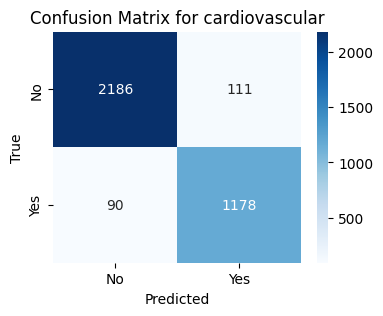

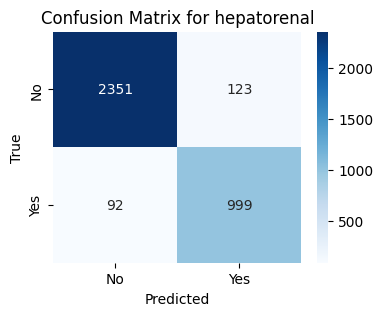

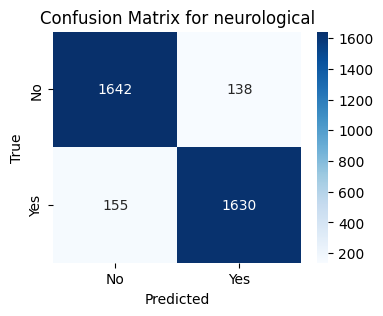

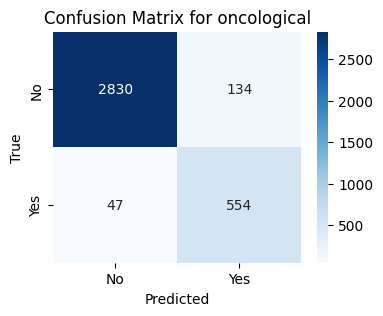

In [389]:
mcm = multilabel_confusion_matrix(y_test,y_pred)
for i, label in enumerate(all_labels):
    cm = mcm[i]
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.title(f"Confusion Matrix for {label}")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

## Guardar resultado

In [386]:
y_pred=clf.predict(X)
y_test=y

In [387]:
# 1. Convertir predicciones binarias a tuplas de texto
predicted_labels_tuples = mlb.inverse_transform(y_pred)

# 2. Unir las tuplas en un solo string separado por '|'
predicted_labels_strings = ['|'.join(labels) for labels in predicted_labels_tuples]

# 3. Crear el DataFrame de salida final
# Usamos el 'test_df' que guardamos al principio para tener acceso a 'title' y 'abstract'
output_df=pd.DataFrame(predicted_labels_strings)
output_df = df[['title', 'abstract']].copy()
output_df['group_predicted'] = predicted_labels_strings
""" output_df.to_csv("predict.csv",index=False) """

' output_df.to_csv("predict.csv",index=False) '

In [388]:
output_df

,title,abstract,group_predicted
0,Adrenoleukodystrophy: survey of 303 cases: bio...,Adrenoleukodystrophy ( ALD ) is a genetically ...,hepatorenal|neurological
1,endoscopy reveals ventricular tachycardia secrets,Research question: How does metformin affect c...,neurological|oncological
2,dementia and cholecystitis: organ interplay,Purpose: This randomized controlled study exam...,hepatorenal
3,The interpeduncular nucleus regulates nicotine...,Partial lesions were made with kainic acid in ...,neurological
4,guillain-barre syndrome pathways in leukemia,Hypothesis: statins improves stroke outcomes v...,neurological
...,...,...,...
3560,The effect of recombinant human insulin-like g...,We recently demonstrated that recombinant hGH ...,cardiovascular|hepatorenal
3561,EEG reveals leukemia secrets,Hypothesis: metformin improves dementia outcom...,neurological
3562,venous pathways in angina pectoris,Hypothesis: metformin improves heart disease o...,cardiovascular
3563,Thyroxine abuse: an unusual case of thyrotoxic...,Eating disorders and the associated behavioura...,neurological


In [390]:
df

,title,abstract,labels,text,embedding
0,Adrenoleukodystrophy: survey of 303 cases: bio...,Adrenoleukodystrophy ( ALD ) is a genetically ...,"[neurological, hepatorenal]",Adrenoleukodystrophy: survey of 303 cases: bio...,"[0.021172656, 0.02166997, -0.07572977, 0.03088..."
1,endoscopy reveals ventricular tachycardia secrets,Research question: How does metformin affect c...,[neurological],endoscopy reveals ventricular tachycardia secr...,"[-0.0076657785, 0.0049243052, -0.006806211, 0...."
2,dementia and cholecystitis: organ interplay,Purpose: This randomized controlled study exam...,[hepatorenal],dementia and cholecystitis: organ interplay Pu...,"[0.033523977, 0.011269818, -0.016054638, 0.043..."
3,The interpeduncular nucleus regulates nicotine...,Partial lesions were made with kainic acid in ...,[neurological],The interpeduncular nucleus regulates nicotine...,"[-0.014952425, -0.0024394898, -0.06930734, 0.0..."
4,guillain-barre syndrome pathways in leukemia,Hypothesis: statins improves stroke outcomes v...,[neurological],guillain-barre syndrome pathways in leukemia H...,"[-0.012434283, -0.021041708, -0.030554863, 0.0..."
...,...,...,...,...,...
3560,The effect of recombinant human insulin-like g...,We recently demonstrated that recombinant hGH ...,"[neurological, cardiovascular, hepatorenal]",The effect of recombinant human insulin-like g...,"[-0.01876637, 0.0017719191, -0.0585729, 0.0454..."
3561,EEG reveals leukemia secrets,Hypothesis: metformin improves dementia outcom...,[neurological],EEG reveals leukemia secrets Hypothesis: metfo...,"[-0.00372124, 0.0057042106, -0.021371147, 0.04..."
3562,venous pathways in angina pectoris,Hypothesis: metformin improves heart disease o...,"[neurological, cardiovascular]",venous pathways in angina pectoris Hypothesis:...,"[0.0072260806, -0.01196728, -0.033628248, 0.07..."
3563,Thyroxine abuse: an unusual case of thyrotoxic...,Eating disorders and the associated behavioura...,[neurological],Thyroxine abuse: an unusual case of thyrotoxic...,"[0.030975027, -0.010566159, -0.066937014, 0.04..."
